In [37]:
!pip install easyfsl
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# Important Libraries

# Splitting dataset
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data import ConcatDataset

# Doing Preview
import numpy as np
import matplotlib.pyplot as plt

# Creating support and query set
import random

# Model Selection
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
from easyfsl.methods import RelationNetworks, TIM

# Training Model
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from statistics import mean
from pathlib import Path
from torch import nn

# Evaluating Trained Model
from easyfsl.methods.utils import evaluate

In [39]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [40]:
from torch.utils.data import Subset, DataLoader, ConcatDataset

image_size = 64

folder1 = ImageFolder(
    root='/content/drive/MyDrive/Colab Notebooks/S4 - Deep Learning/Final Project/Datased_jpg',
    transform=transforms.Compose([
        transforms.Resize([int(image_size), int(image_size)]),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]), # Flip is needed for better prediction?
)

folder2 = ImageFolder(
    root='/content/drive/MyDrive/Colab Notebooks/S4 - Deep Learning/Final Project/Datased_jpg',
    transform=transforms.Compose([
        transforms.Resize([int(image_size), int(image_size)]),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]), # Flip is needed for better prediction?
)

# select the indices of all other folders - Angka di akhir menandakan index
train_idx1 = [i for i in range(len(folder1)) if folder1.imgs[i][1] <= 6]
train_idx2 = [i for i in range(len(folder2)) if folder2.imgs[i][1] <= 6]

valid_idx1 = [i for i in range(len(folder1)) if ((folder1.imgs[i][1] > 6) & (folder1.imgs[i][1] <= 10))]
valid_idx2 = [i for i in range(len(folder2)) if ((folder2.imgs[i][1] > 6) & (folder2.imgs[i][1] <= 10))]

test_idx1 = [i for i in range(len(folder1)) if folder1.imgs[i][1] > 10]
test_idx2 = [i for i in range(len(folder2)) if folder2.imgs[i][1] > 10]

# build the appropriate subset
train_set = ConcatDataset([Subset(folder1, train_idx1),Subset(folder2, train_idx2)])
valid_set = ConcatDataset([Subset(folder1, valid_idx1),Subset(folder2, valid_idx2)])
test_set = ConcatDataset([Subset(folder1, test_idx1),Subset(folder2, test_idx2)])

print("train_set length:", len(train_set))
print("valid_set length:", len(valid_set))
print("test_set length:", len(test_set))

train_set length: 140
valid_set length: 80
test_set length: 80


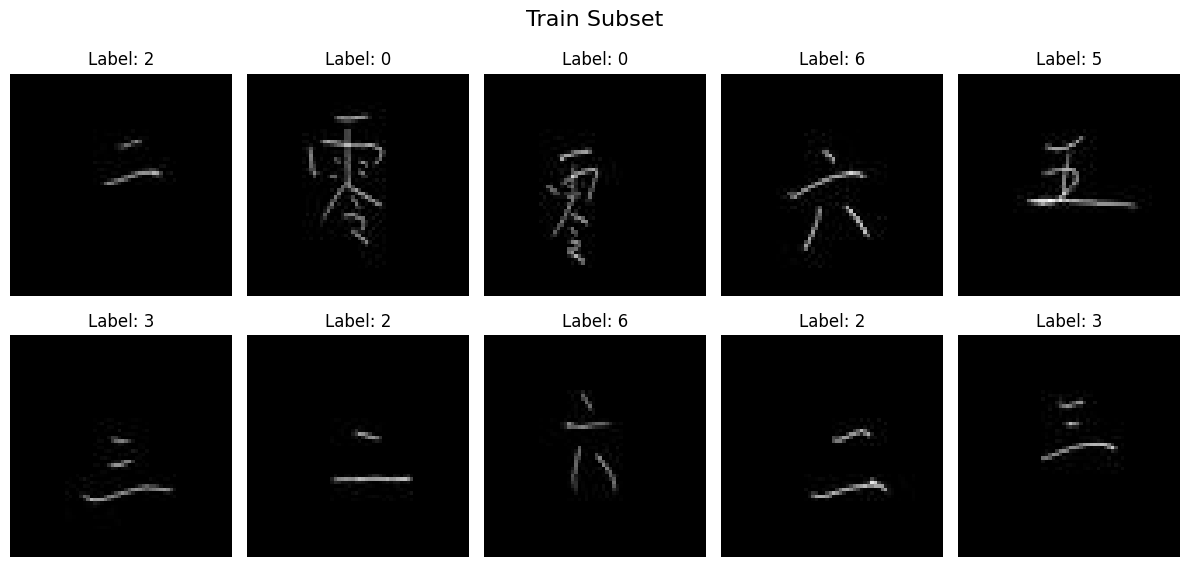

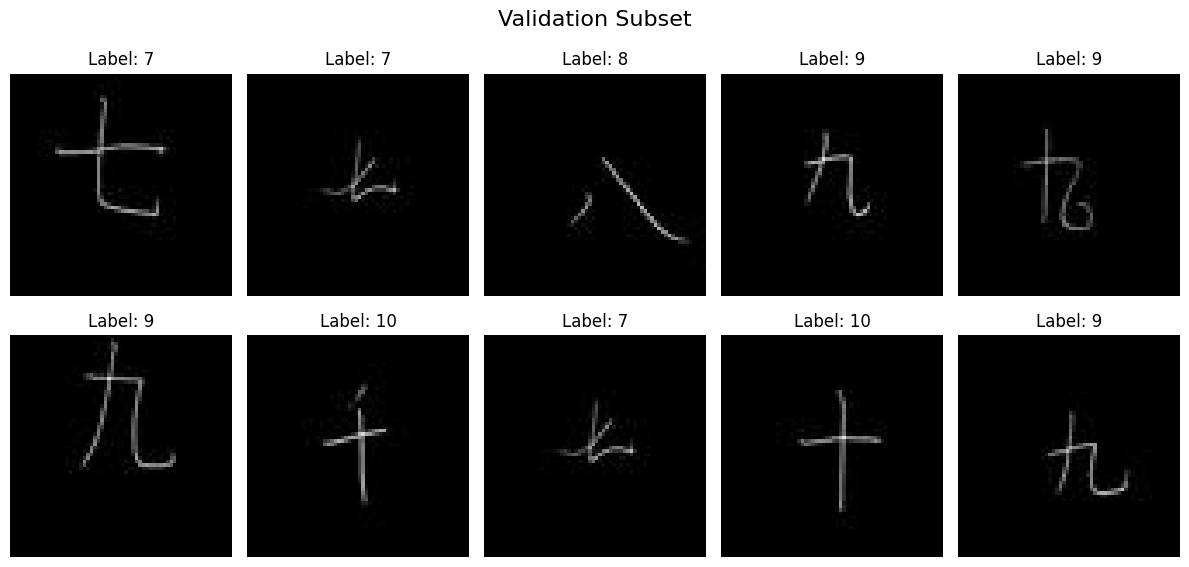

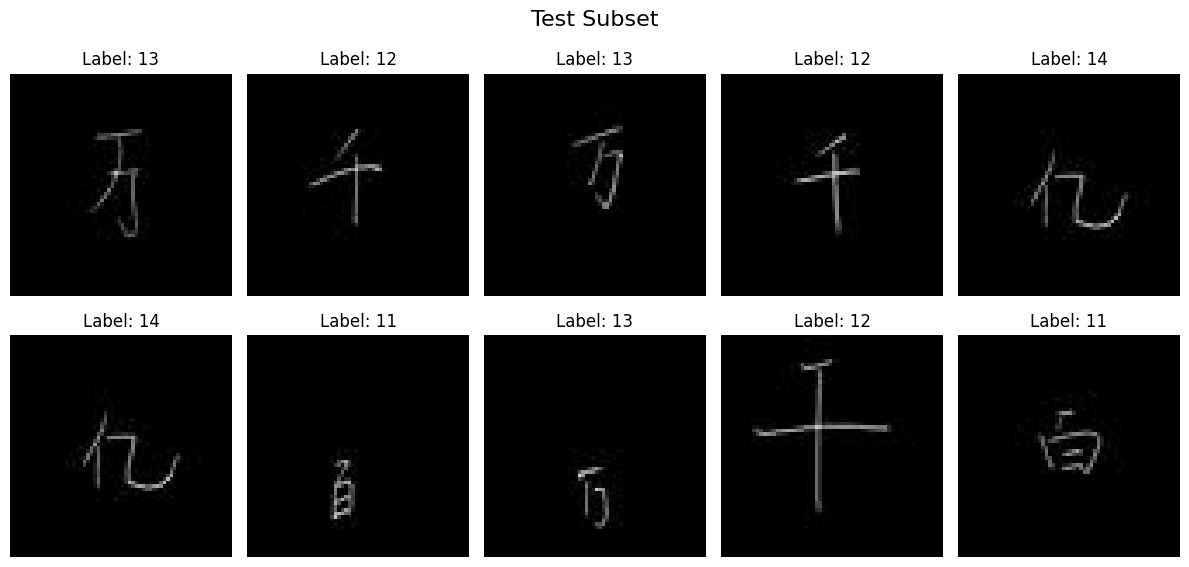

In [41]:
import random
import matplotlib.pyplot as plt


# define a function to plot images
def plot_images(images, labels, title):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(len(images)):
        img = images[i].permute(1, 2, 0).numpy()
        label = labels[i]
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# define a function to plot random images from a subset
def plot_random_images(subset, num_images, title):
    images, labels = zip(*[subset[random.randint(0, len(subset)-1)] for _ in range(num_images)])
    plot_images(images, labels, title)

# plot 10 random images from each subset
plot_random_images(train_set, 10, 'Train Subset')
plot_random_images(valid_set, 10, 'Validation Subset')
plot_random_images(test_set, 10, 'Test Subset')

In [42]:
from torch.utils.data import DataLoader

batch_size = 32
n_workers = 12

train_set.get_labels = lambda: [
    instance[1] for instance in train_set
]
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=True,
    shuffle=True,
)

In [43]:
from easyfsl.samplers import TaskSampler

n_way = 3
n_shot = 1
n_query = 10
n_validation_tasks = 200
valid_set.get_labels = lambda: [
    instance[1] for instance in valid_set
]
val_sampler = TaskSampler(
    valid_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)
val_loader = DataLoader(
    valid_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

In [44]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Multiple Model Training and Optimizer

In [45]:
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
from easyfsl.methods import RelationNetworks, TIM, MatchingNetworks, PrototypicalNetworks
from easyfsl.modules import resnet12

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet12(
    use_fc=True,
    num_classes=15,
    # use_pooling = False # Turn this off when not using RelationNetwork
).to(DEVICE)
# model.set_use_fc(False) # Turn this off when not using RelationNetwork

# TIM - 0% accuracy in epoch - can load prediction
few_shot_classifier = TIM(model).to(DEVICE)

# RelationNet - error in backbone?
# few_shot_classifier = RelationNetworks(model).to(DEVICE)

# MatchingNet - 0.20% accuracy in epoch - can't load prediction
# few_shot_classifier = MatchingNetworks(model).to(DEVICE)

# ProtoNet - 0% accuracy in epoch - can load prediction
# few_shot_classifier = PrototypicalNetworks(model).to(DEVICE)

In [46]:
# SGD OPTIMIZER #

from torch.optim import SGD, Adam, RMSprop, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from statistics import mean
from pathlib import Path
from torch import nn

LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 20
scheduler_milestones = [150, 180]
scheduler_gamma = 0.1
learning_rate = 1e-01
tb_logs_dir = Path(".")

train_optimizer = SGD(
    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)

# train_optimizer = Adam(
#     model.parameters(), lr=learning_rate, weight_decay=5e-4
# )

# train_optimizer = RMSprop(
#     model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
# )

train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [47]:
def training_epoch(model_: nn.Module, data_loader: DataLoader, optimizer: Optimizer):
    all_loss = []
    model_.train()
    with tqdm(data_loader, total=len(data_loader), desc="Training") as tqdm_train:
        for images, labels in tqdm_train:
            optimizer.zero_grad()

            loss = LOSS_FUNCTION(model_(images.to(DEVICE)), labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [48]:
def evaluate(model_, data_loader, device, tqdm_prefix="Evaluation"):
    correct = 0
    total = 0
    with tqdm(data_loader, total=len(data_loader), desc=tqdm_prefix) as tqdm_eval:
        for batch in tqdm_eval:
            images, *labels = batch
            label = labels[0]
            images = images.to(device)
            label = label.to(device)
            outputs = model_(images)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            tqdm_eval.set_postfix({
                "accuracy": f"{100*correct/total:.2f}%",
                "total": total
            })
    return correct / total


In [49]:
model.requires_grad_(True)
best_state = model.state_dict()
best_validation_accuracy = 0.0
validation_frequency = 5
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)

    if epoch % validation_frequency == validation_frequency - 1:

        # We use this very convenient method from EasyFSL's ResNet to specify
        # that the model shouldn't use its last fully connected layer during validation.
        model.set_use_fc(False) #     [Turn this off when using other than resnet model]
        validation_accuracy = evaluate(
            model, val_loader, device=DEVICE, tqdm_prefix="Validation"
        )
        model.set_use_fc(True) #     [Turn this off when using other than resnet model]

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_state = model.state_dict()
            print("Ding ding ding! We found a new best model!")

        tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    tb_writer.add_scalar("Train/loss", average_loss, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()


Epoch 0


Training: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s, loss=3.66]


Epoch 1


Training: 100%|██████████| 5/5 [00:01<00:00,  3.72it/s, loss=3.61]


Epoch 2


Training: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s, loss=1.84]


Epoch 3


Training: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s, loss=1.38]


Epoch 4


Validation: 100%|██████████| 200/200 [00:13<00:00, 15.30it/s, accuracy=0.00%, total=600]


Epoch 5


Training: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s, loss=1.12]


Epoch 6


Training: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s, loss=1.07]


Epoch 7


Training: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, loss=0.924]


Epoch 8


Training: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s, loss=0.668]


Epoch 9


Validation: 100%|██████████| 200/200 [00:14<00:00, 13.46it/s, accuracy=0.00%, total=600]


Epoch 10


Training: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s, loss=0.407]


Epoch 11


Training: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s, loss=0.397]


Epoch 12


Training: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=0.348]


Epoch 13


Training: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s, loss=0.225]


Epoch 14


Validation: 100%|██████████| 200/200 [00:08<00:00, 24.27it/s, accuracy=0.00%, total=600]


Epoch 15


Training: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s, loss=0.386]


Epoch 16


Training: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s, loss=0.511]


Epoch 17


Training: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s, loss=0.252]


Epoch 18


Training: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s, loss=0.105]


Epoch 19


Validation: 100%|██████████| 200/200 [00:09<00:00, 21.02it/s, accuracy=0.00%, total=600]


In [50]:
model.load_state_dict(best_state)

<All keys matched successfully>

In [36]:
n_test_tasks = 1000
from easyfsl.methods.utils import evaluate

n_way = 3
n_shot = 1
n_query = 10

test_set.get_labels = lambda: [
    instance[1] for instance in test_set
]
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [51]:
# Evaluate the model on the test set

def evaluate_acc(model_, data_loader, device):
    correct = 0
    total = 0
    model_.eval()
    with torch.no_grad():
        for images, labels, *_ in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

model.set_use_fc(False)
model.requires_grad_(False)
test_accuracy = evaluate_acc(model, test_loader, DEVICE)
print(f"Test accuracy: {(100 * test_accuracy):.2f} %")


Test accuracy: 0.00 %


In [52]:
import tensorflow as tf
def predict_on_one_task(
    model,
    support_images,
    support_labels,
    query_images,
    query_labels,
) -> [int, int]:
    model.process_support_set(support_images, support_labels)
    return torch.max(
            model(query_images).detach().data,
            1,
        )[1]

    


def predict(
    model,
    data_loader,
    device: str = "cuda",
    use_tqdm: bool = True,
    tqdm_prefix: str = None,
    GRID=[5,6], SIZE=(30,25)
) -> float:

    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph
    model.eval()
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)
    
    i=1
    with torch.no_grad():
        with tqdm(
            enumerate(data_loader),
            total=len(data_loader),
            disable=not use_tqdm,
#             desc=tqdm_prefix,
        ) as tqdm_eval:
#             print(tqdm_eval)
            for _, (
                support_images,
                support_labels,
                query_images,
                query_labels,
                _,
            ) in tqdm_eval:
                pred = predict_on_one_task(
                    model,
                    support_images.to(device),
                    support_labels.to(device),
                    query_images.to(device),
                    query_labels.to(device),
                )
#                 print(pred)
                
                id = np.random.randint(len(query_images))
                image, label = tf.expand_dims(query_images[id].T,axis=0), class_names[int(query_labels[id])]
                title = "True : {}\nPred : {}\n".format(label, class_names[int(pred[id])])
                plt.subplot(n_rows, n_cols, i)
                plt.imshow(image[0])
                plt.axis('off')
                plt.title(title)

                i+=1
                if i>n_images: break
                



  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-52-fa1d74b77567>:64: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  image, label = tf.expand_dims(query_images[id].T,axis=0), class_names[int(query_labels[id])]
  3%|▎         | 29/1000 [00:08<04:50,  3.35it/s]


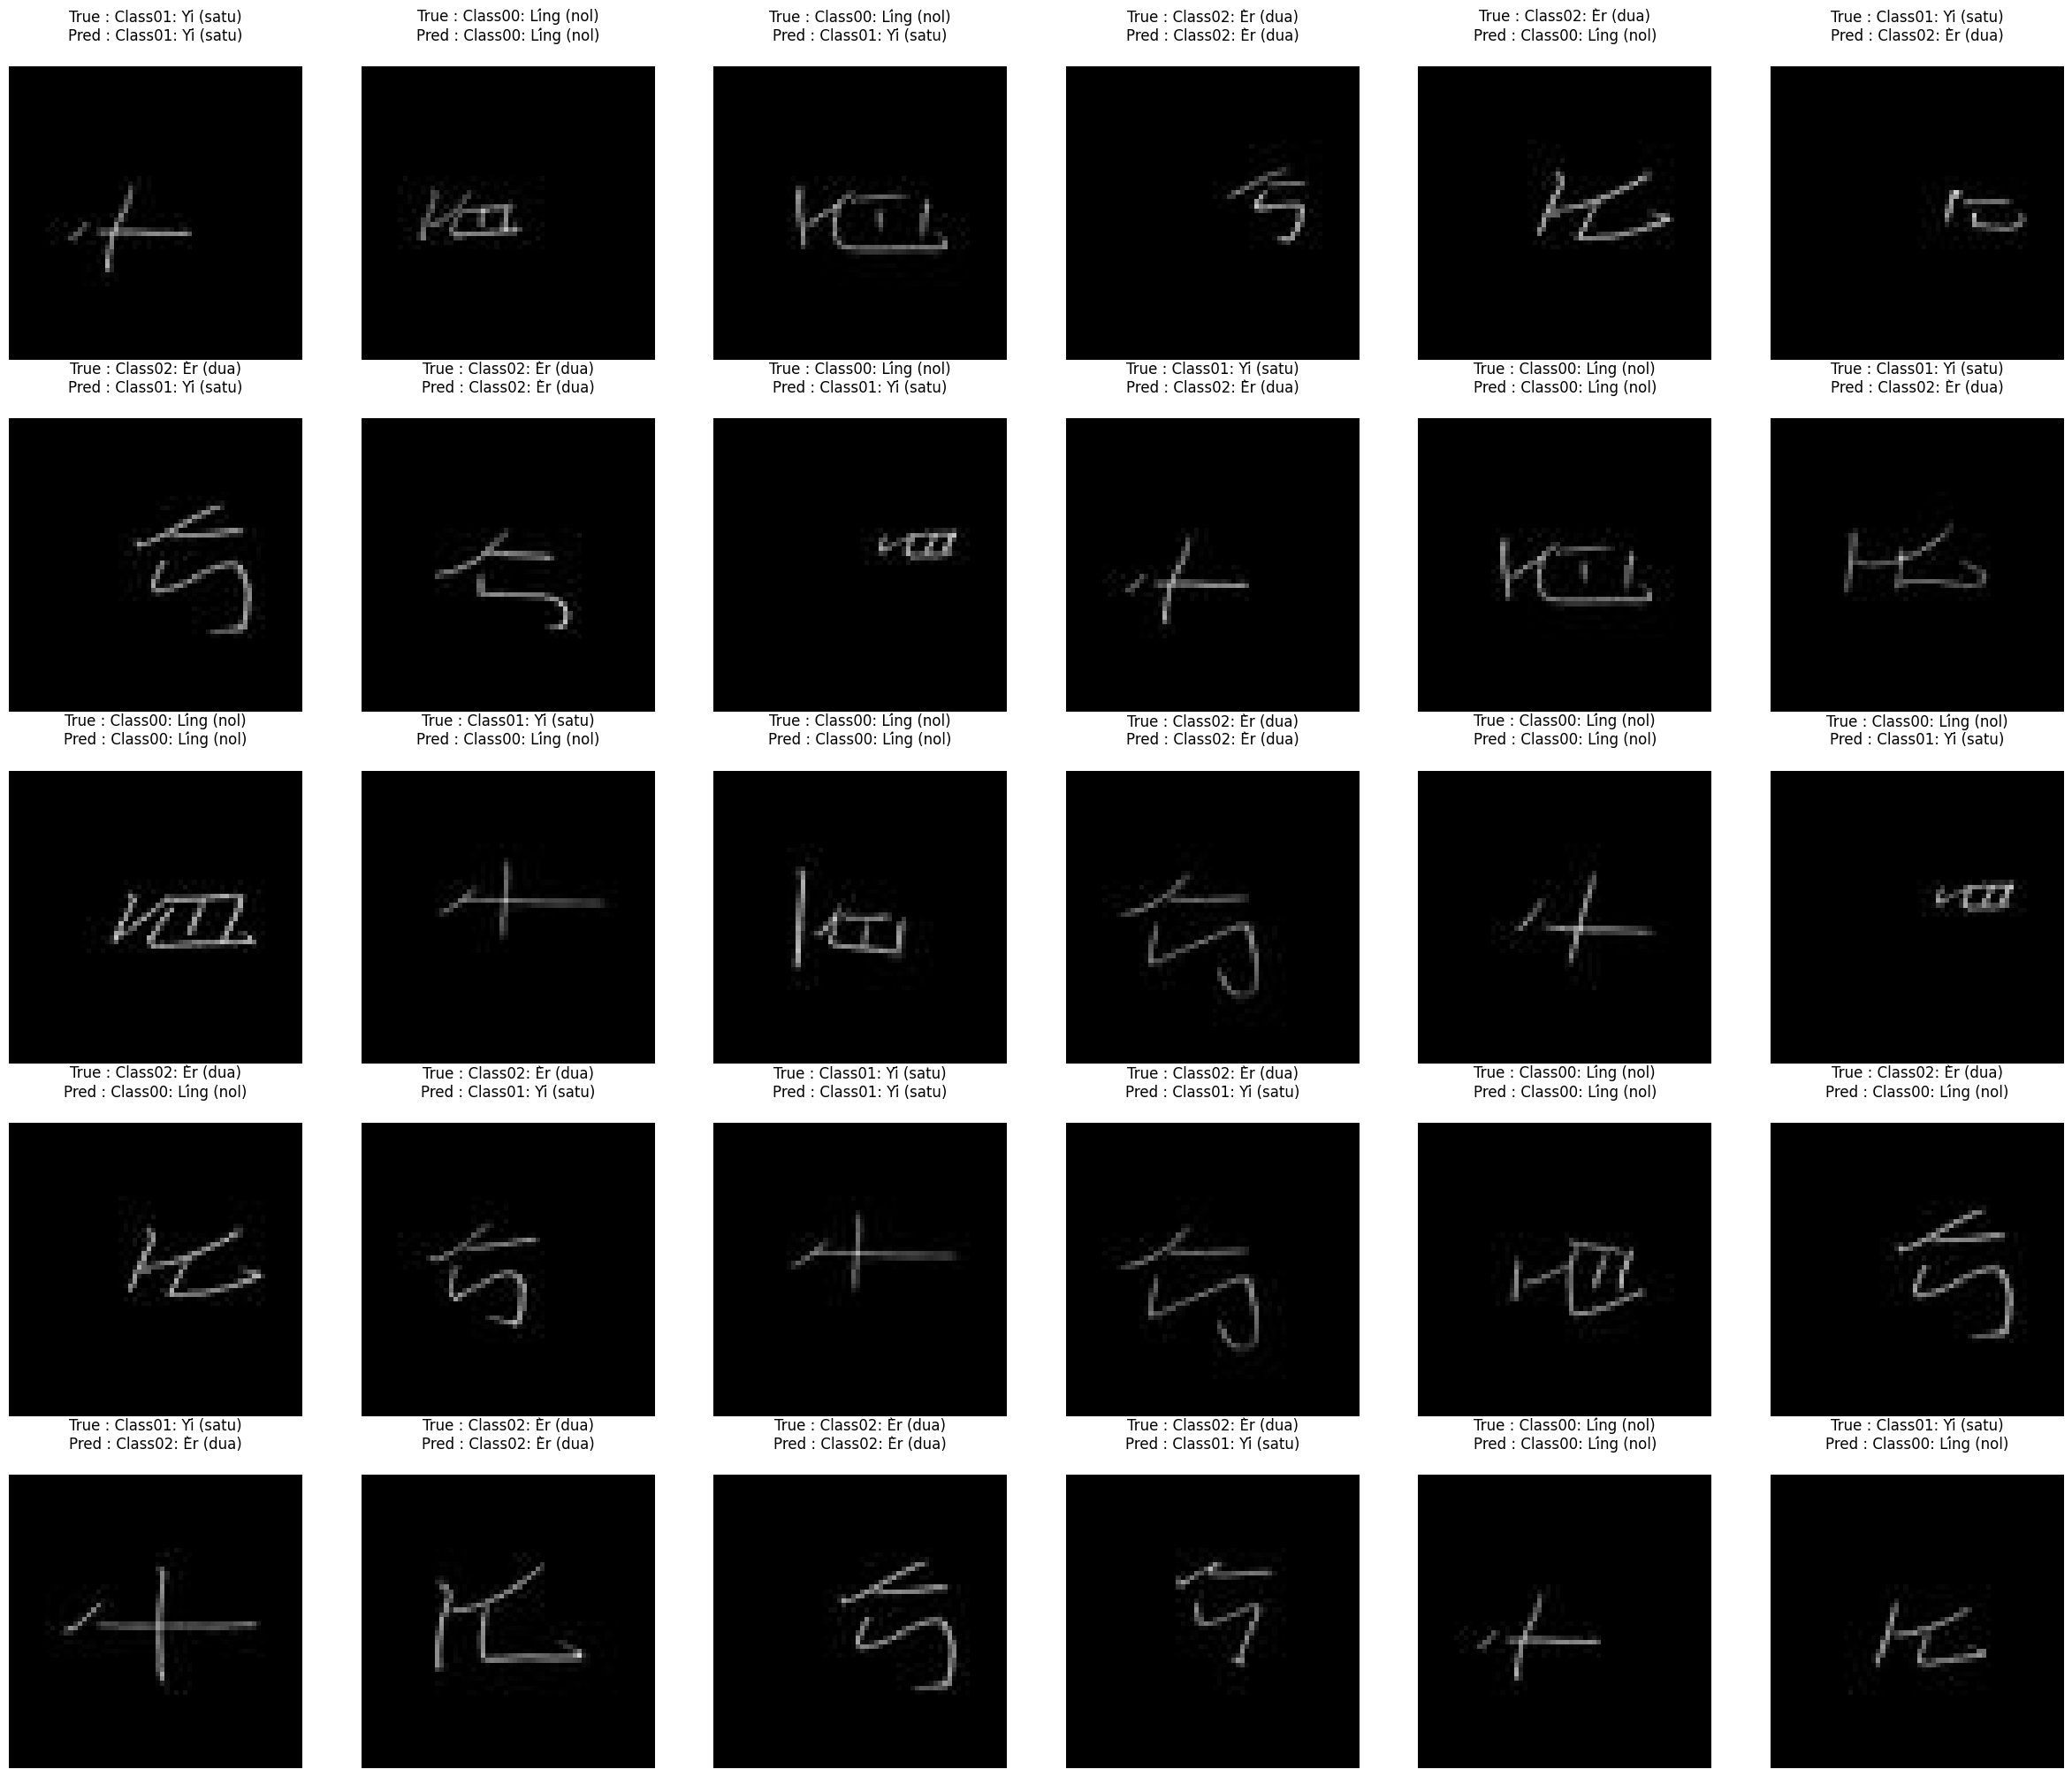

In [53]:
import os

class_names = sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/S4 - Deep Learning/Final Project/Datased_jpg'))
n_classes   = len(class_names)

predict(few_shot_classifier, test_loader, device=DEVICE)